In [272]:
import glob
import xarray as xr
import os
import numpy as np
import warnings
import sys
import pickle
import matplotlib.pyplot as plt
sys.path.insert(0, '/home/disk/p/jkcm/Code')
from Lagrangian_CSET.CSET_data_classes import CSET_Flight
from Lagrangian_CSET import utils
from Lagrangian_CSET import met_utils as mu
from Lagrangian_CSET.LoopTimer import LoopTimer
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
#loading all CSET profiles
flights = {}
print("loading flights")
for _, flight in sorted(utils.datemap.items()):
    print(flight)
    if flight == 'RF16'
        continue
    f = CSET_Flight(flight)
    f.add_legs()
    flights[flight] = f

loading flights
RF01
RF02
RF03
RF04
RF05
RF06
RF07
RF08
RF09
RF10
RF11
RF12
RF13
RF14
RF15
RF16


ValueError: Missing or incorrect input, printing help

specify the RESEARCH FLIGHTS (rf_num) you want as list.
options are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
or select 'all'

In [ ]:
profiles = {}
for name, flight in sorted(flights.items()):
    profs = flight.get_profiles()
    for seq, p in profs.items():
        profiles['{}_{}'.format(name, seq)] = p

In [53]:
def get_data_from_dropsonde(file):
#    file = os.path.join(dropsonde_dir, 'D20150712_201424_PQC.nc')

    data = xr.open_dataset(file)
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        index = data.GPSAlt.values < 4000

    ret = {}
    ret['TIME']=utils.as_datetime(data.time_offset.values[index])
    ret['GGLAT']=data.Lat.values[index]
    ret['GGLON']=data.Lon.values[index]
    ret['GGALT']=data.GPSAlt.values[index]
    ret['RHUM']=data.RH.values[index]
    ret['ATX']=data.Temp.values[index]+273.15
    ret['PSX']=data.Press.values[index]
    ret['DPXC']= data.Dewpt.values[index]+273.15
    ret['QV'] = mu.qv_from_p_T_RH(ret['PSX']*100, ret['ATX'], ret['RHUM'])*1000
    ret['MR'] = ret['QV']/(1-ret['QV']/1000)
    ret['TVIR'] = mu.tvir_from_T_w(ret['ATX'], ret['MR']/1000)
    ret['DENS'] = mu.density_from_p_Tv(ret['PSX']*100, ret['TVIR'])  

    ret['THETA']= mu.theta_from_p_T(ret['PSX'], ret['ATX'])
    ret['THETAE']= mu.thetae_from_t_tdew_mr_p(ret['ATX'], ret['DPXC'], ret['MR']/1000, ret['PSX']*100) #equiv pot temp, K we can get this if we really want

    ret['QL'] = np.full_like(ret['PSX'], fill_value=np.nan)
    ret['THETAL'] = np.full_like(ret['PSX'], fill_value=np.nan)
    ret['PLWCC']=  np.full_like(ret['PSX'], fill_value=np.nan)
    return ret


def get_data_from_flight(flight_num, start=None, end=None, var_list=[]):

    flight_file = glob.glob(os.path.join(utils.CSET_flight_dir, 'RF{:02d}*.nc'.format(flight_num)))[0]
    data = xr.open_dataset(flight_file)#, decode_times=False)
#     data['time'] = nc.num2date(data.Time[:],units=data.Time.units)
    dates = utils.as_datetime(data.Time.values)
    alt = data['GGALT'].values
    if start is None:
        start = dates[0]
    if end is None:
        end = dates[-1]
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        index = np.logical_and(np.logical_and(dates >= start, dates <= end), alt < 3600)
    
    [(k, v.long_name) for k,v in data.data_vars.items() if 'Pres' in v.long_name]
    ret = {}
    ret['TIME'] = dates[index]
    for i in var_list:
        if i == 'ATX':
            ret[i] = data[i].values[index]+273.15
        else:
            ret[i] = data[i].values[index]
    
    ret['DENS'] = mu.density_from_p_Tv(data['PSX'].values[index]*100, data['TVIR'].values[index]+273.15)  
    ret['QL'] = data['PLWCC'].values[index]/ret['DENS']
    ret['THETAL'] = mu.get_liquid_water_theta(ret['ATX'], ret['THETA'], ret['QL'])
    ret['QV'] = data['MR'].values[index]/(1+data['MR'].values[index]/1000)
    return ret    

reload=False
if reload:
    path = r'/home/disk/eos4/jkcm/Data/CSET/LookupTable_all_flights.xls'
    flight = utils.read_CSET_Lookup_Table(path, 
                                       rf_num='all', 
                                       legs=['d', 'k'],
                                       variables=['Date', 'ST', 'ET'])
    start_times = utils.as_datetime([utils.CSET_date_from_table(d, t) for d, t in
                   zip(flight['Date']['values'], flight['ST']['values'])])
    end_times = utils.as_datetime([utils.CSET_date_from_table(d, t) for d, t in
                 zip(flight['Date']['values'], flight['ET']['values'])])
    sounding_times = list(zip(flight['rf'], start_times, end_times))

    # %% read in data    
    # get flight info for each sounding
    var_list = ['GGLAT', 'GGLON', 'GGALT', 'RHUM', 'ATX', 'MR', 'THETAE', 'THETA', 'PSX', 'DPXC', 'PLWCC']
    soundings = []
    lt = LoopTimer(len(sounding_times))
    print("processing soundings...\n")
    for i in sounding_times:
        lt.update()
        soundings.append(get_data_from_flight(i[0], i[1], i[2], var_list))

    sondes = []
    sonde_files = glob.glob(os.path.join(utils.dropsonde_dir, "*.nc"))
    for f in sonde_files:
        sondes.append(get_data_from_dropsonde(f))

    data_loc = r'/home/disk/eos4/jkcm/Data/CSET/Python/'
    with open(os.path.join(data_loc, 'sondes.pickle'), 'wb') as f:
        pickle.dump(sondes, f, pickle.HIGHEST_PROTOCOL)
    with open(os.path.join(data_loc, 'soundings.pickle'), 'wb') as f:
        pickle.dump(soundings, f, pickle.HIGHEST_PROTOCOL)
        
if not reload:
    data_loc = r'/home/disk/eos4/jkcm/Data/CSET/Python/'
    with open(os.path.join(data_loc, 'sondes.pickle'), 'rb') as f:
        sondes = pickle.load(f)
    with open(os.path.join(data_loc, 'soundings.pickle'), 'rb') as f:
        soundings = pickle.load(f)

processing soundings...

100.00%      ETA 16:21:11      time left: 0 seconds       

In [87]:
locs = []
for snd in sondes + soundings:
    lat = np.nanmean(snd['GGLAT'])
    lon = np.nanmean(snd['GGLON'])
    time = snd['TIME'][len(snd['TIME'])//2]
    locs.append((lat, lon, time))

with open(os.path.join(data_loc, 'locs.pickle'), 'wb') as f:
        pickle.dump(locs, f, pickle.HIGHEST_PROTOCOL)

In [280]:
len(soundings)

80

In [88]:
with open(os.path.join(data_loc, 'locs_by_scene.pickle'), 'rb') as f:
        locs_by_scene = pickle.load(f)

In [270]:
scene_dict = {-1: 'NC',
              0: 'open',
              1: 'closed',
              2: 'homogen',
              3: 'disorg',
              4: 'too clear'}

snds_by_scene = {-1: [],
                 0: [],
                 1: [],
                 2: [],
                 3: [],
                 4: []}
for snd in sondes + soundings:
    lat = np.nanmean(snd['GGLAT'])
    lon = np.nanmean(snd['GGLON'])
    time = snd['TIME'][len(snd['TIME'])//2]
    
    for sc, locs in locs_by_scene.items():
        times = [i[2] for i in locs]
        if time in times:
            snds_by_scene[sc].append(snd)

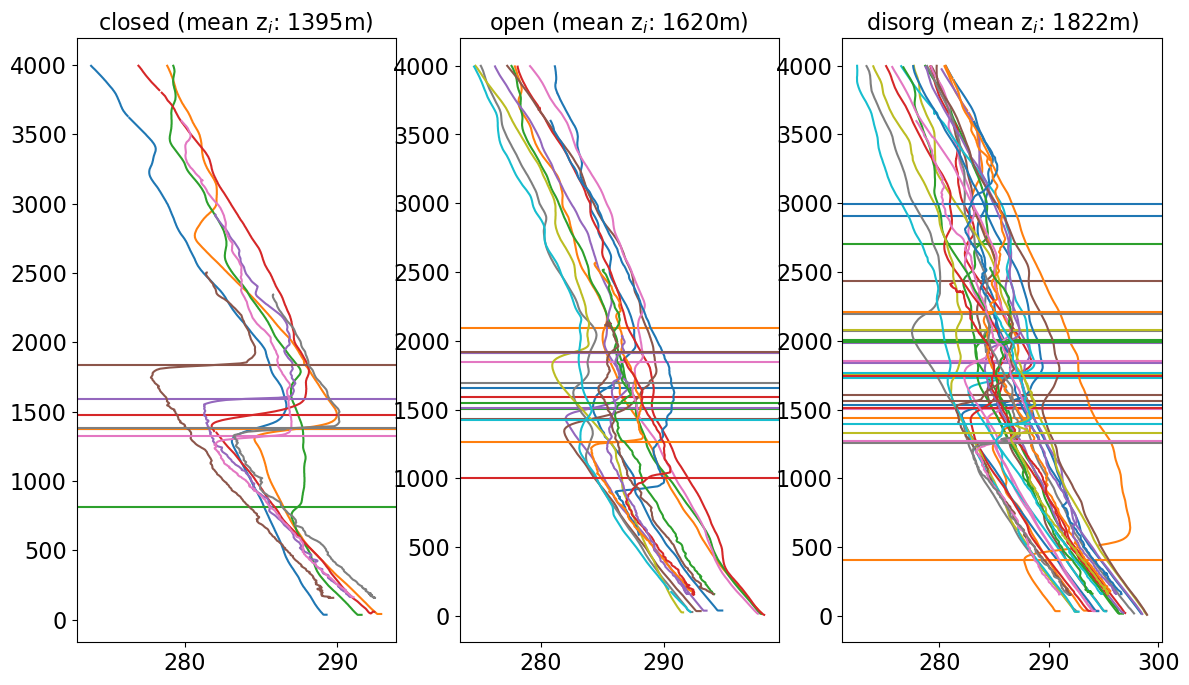

In [286]:
def add_sounding_to_plot(sounding, ax, var):
    z=sounding['GGALT']

    try:
        dec = mu.calc_decoupling_from_sounding(sounding)
    except ValueError as e:
        raise e
    p = ax.plot(sounding[var], z)
    try:
#         print(dec['i_mid'])
        ax.axhline(dec['z_mid'], c=p[0].get_color())
        return dec
    except IndexError as e:
        return dec


fig, [ax1, ax2, ax3] = plt.subplots(nrows=1, ncols=3, figsize=(14,8))
all_hgts = {}
all_decs = {}
all_dts = {}
for axi, scene in zip([ax1, ax2, ax3], [1, 0, 3]):
    hgts = []
    decs = []
    dts = []
    for snd in snds_by_scene[scene]:
        dec = add_sounding_to_plot(snd, axi, var='ATX')
        if scene==3:
            if dec['z_mid'] < 500:
                low_snd = snd
        try:
            hgts.append((dec['z_mid']))
            decs.append(dec['alpha_qt'])
            dts.append(dec['d_t_inv'])
        except IndexError as e:
            continue
    all_hgts[scene] = hgts
    all_decs[scene] = decs
    all_dts[scene] = dts
    axi.set_title("{} (mean z$_i$: {:0.0f}m)".format(str(scene_dict[scene]), np.nanmean(hgts)))
#     print('{} (mean alpha_qt {:0.2f})'.format(str(scene_dict[scene]), np.nanmean(decs)))

# fig.savefig("/home/disk/p/jkcm/plots/agu/profiles.png", dpi=600, bbox_inches='tight')


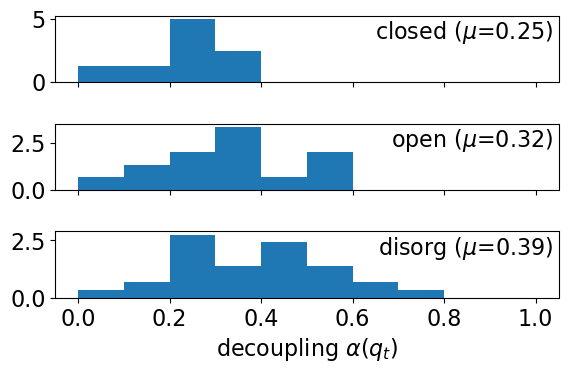

In [284]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,4))

for axi, scene in zip(ax, [1,0,3]):
    decs = all_decs[scene]
    axi.hist(np.array(decs)[~np.isnan(decs)], bins = np.linspace(0,1,11), density=True)
    axi.annotate('{} ($\mu$={:0.2f})'.format(str(scene_dict[scene]), np.nanmean(decs)), xy=(0.99, 0.95), xycoords='axes fraction', 
                 verticalalignment='top', horizontalalignment='right', fontsize=16)
# plt.suptitle(r"decoupling $\alpha(q_t)$", y=1.1)
ax[2].set_xlabel(r"decoupling $\alpha(q_t)$")
fig.tight_layout()

fig.savefig("/home/disk/user_www/jkcm/misc/agu/decoupling.png", dpi=600, bbox_inches='tight')

# plt.hist(np.array(all_decs[0])[~np.isnan(all_decs[0])], bins = np.linspace(0,1,11))

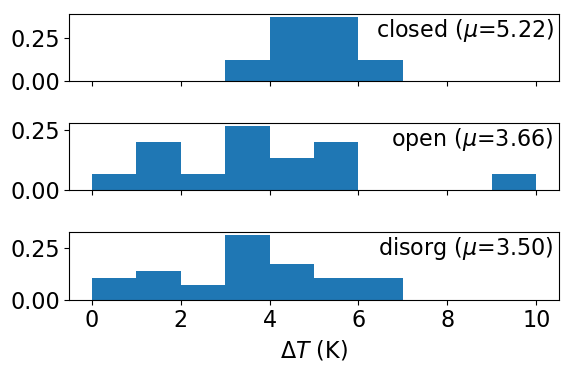

In [285]:
fig, ax = plt.subplots(nrows=3, sharex=True, figsize=(6,4))

for axi, scene in zip(ax, [1,0,3]):
    dts = all_dts[scene]
    axi.hist(np.array(dts)[~np.isnan(dts)], bins = np.linspace(0,10,11), density=True)
    axi.annotate('{} ($\mu$={:0.2f})'.format(str(scene_dict[scene]), np.nanmean(dts)), xy=(0.99, 0.95), xycoords='axes fraction', 
                 verticalalignment='top', horizontalalignment='right', fontsize=16)
ax[2].set_xlabel(r"$\Delta T$ (K)")
# plt.suptitle(r"inversion $\Delta t$", y=1.1)
fig.tight_layout()

fig.savefig("/home/disk/user_www/jkcm/misc/agu/temp_jump.png", dpi=600, bbox_inches='tight')


In [297]:
print(np.nanmean(low_snd['GGLAT']))
print(360+np.nanmean(low_snd['GGLON']))
(low_snd['TIME'][500])

35.82284
234.00721740722656


datetime.datetime(2015, 7, 29, 23, 24, 28, tzinfo=<UTC>)